### Get `RGB-D` image from D435i

W:  1280
H:  720
FPS:  30
Depth Scale is: 0.0010 m


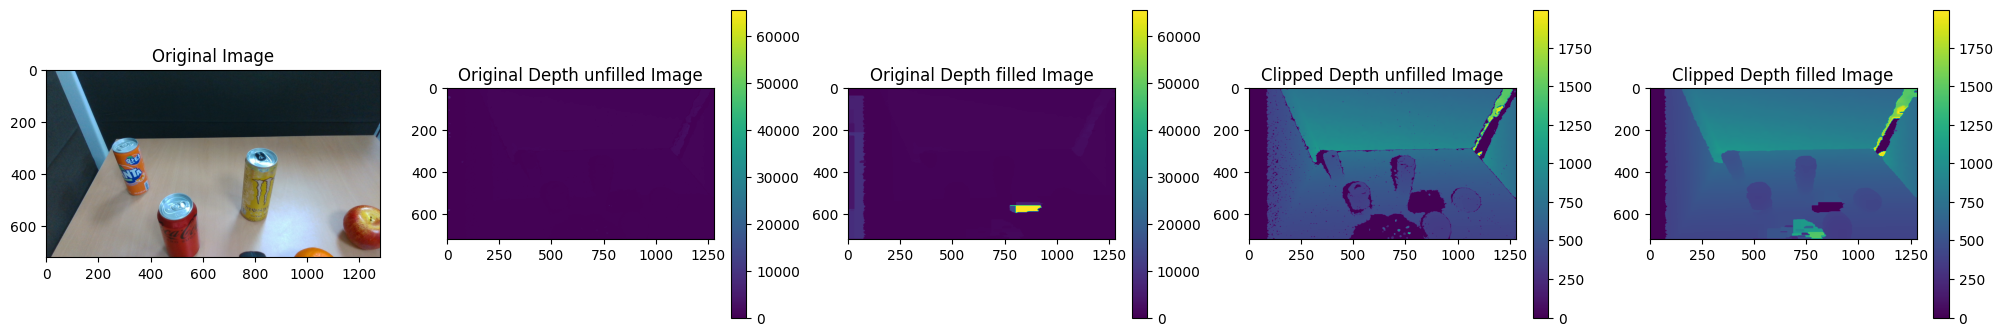

Frames Captured: Clean image


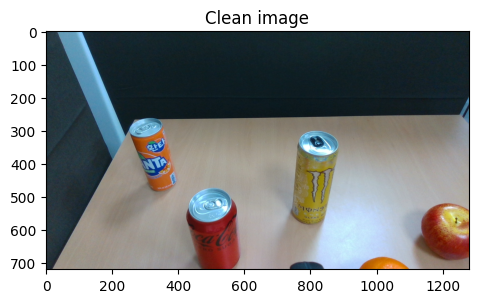

In [2]:
import json
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Setup:
pipe = rs.pipeline()
cfg = rs.config()

# setting pre-defined camera parameters.
jsonObj = json.load(open("./cam_setting.json"))
json_string= str(jsonObj).replace("'", '\"')

print("W: ", int(jsonObj["viewer"]['stream-width']))
print("H: ", int(jsonObj["viewer"]['stream-height']))
print("FPS: ", int(jsonObj["viewer"]['stream-fps']))

cfg.enable_stream(rs.stream.depth, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.z16, int(jsonObj["viewer"]['stream-fps']))
cfg.enable_stream(rs.stream.color, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.bgr8, int(jsonObj["viewer"]['stream-fps']))
cfg = pipe.start(cfg)
for x in range(100):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
rgb_image = frameset.get_color_frame()
depth_image = frameset.get_depth_frame()

####
depth_sensor = cfg.get_device().first_depth_sensor()        # depth sensor에 대한 것들을 얻자
depth_scale = depth_sensor.get_depth_scale()                # 깊이 센서의 깊이 스케일 얻음
print(f"Depth Scale is: {depth_scale:.4f} m")
align_to = rs.stream.color
align = rs.align(align_to)
aligned_frames = align.process(frameset)
aligned_depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()
# Apply filter to fill the Holes in the depth image
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 3)
filtered_depth = spatial.process(depth_image)
hole_filling = rs.hole_filling_filter()
filled_depth = hole_filling.process(filtered_depth)
#####

depth_image_unfilled = np.asanyarray(depth_image.get_data())
depth_image_filled = np.asanyarray(filled_depth.get_data())
color_image = np.asanyarray(rgb_image.get_data())
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

grey_color = 0
clipping_distance_in_meters = 2    # 1 meter, 클리핑할 영역을 1m로 설정
clipping_distance = clipping_distance_in_meters / depth_scale   #스케일에 따른 클리핑 거리
depth_clipped_unfilled = np.where((depth_image_unfilled > clipping_distance) | (depth_image_unfilled <= 0), grey_color, depth_image_unfilled)
depth_clipped_filled = np.where((depth_image_filled > clipping_distance) | (depth_image_filled <= 0), grey_color, depth_image_filled)

plt.figure(figsize=(25,4))
plt.subplot(1,5,1)
plt.title("Original Image")
plt.imshow(color_image)
# plt.show()

plt.subplot(1,5,2)
plt.title("Original Depth unfilled Image")
plt.imshow(depth_image_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,3)
plt.title("Original Depth filled Image")
plt.imshow(depth_image_filled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,4)
plt.title("Clipped Depth unfilled Image")
plt.imshow(depth_clipped_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,5)
plt.title("Clipped Depth filled Image")
plt.imshow(depth_clipped_filled)
plt.colorbar()
plt.show()


# # Cleanup:
order = '6'
obj1_name= 'kikat'
direction= 'front'
obj2_name= 'pockey' 
# image_name = 'shape_0'
image_name = f'shape_{order}_{obj1_name}_move_to_{direction}_{obj2_name}'
pipe.stop()
print("Frames Captured: Clean image")
clean_rgb_image = color_image
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(1,2,1)
plt.title("Clean image")
plt.imshow(clean_rgb_image)
plt.imsave(f'./realworld-images/shape/3/{image_name}'+'_color.png', clean_rgb_image)
np.save(f'./realworld-images/shape/3/{image_name}'+'_depth_clip.npy', depth_clipped_filled)
np.save(f'./realworld-images/shape/3/{image_name}'+'_depth_unclip.npy', depth_clipped_unfilled)
np.save(f'./realworld-images/shape/3/{image_name}'+'_color.npy', clean_rgb_image)

# plt.show()


### Chat with `MLLM`

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
import openai
import cv2,os
import sys
import argparse
sys.path.append('../')
from models.utils.util import  *
from models.utils.gpt_helper import (GPT4VisionClass,printmd, response_to_json, parse_and_get_action,
                                     extract_arguments, match_objects, decode_image)
print ("openai version:[%s]"%(openai.__version__))

def extract_number(filename):
    # Extract the number from the filename using regular expression
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else float('inf')
#%%
parser = argparse.ArgumentParser(description='EXP1-Rationale: Interaction Accuracy, Preference Accuracy')
parser.add_argument('--save_path', type=str, default='./results/', help='Save path')
parser.add_argument('--gpt_model', type=str, default='gpt-4-vision-preview', choices=['gpt-4-vision-preview', 'gpt-4', 'gpt-3.5-turbo'], help='Select GPT model')
args = parser.parse_args(args=[])

openai version:[1.7.1]


In [5]:
# 1. Start with Image description
model = GPT4VisionClass(key_path='../key/rilab_key.txt', max_tokens=1024, temperature=0.9,
    gpt_model="gpt-4-vision-preview",
    role_msg="You are a helpful agent with vision capabilities; do not respond to objects not depicted in images."
    )

# 2. System prompt: functions, object_names
print("\033[94m [System prompt: infrom the format of the answer] \033[0m")


key_path:[../key/rilab_key.txt]

Chat agent using  initialized with the follow role:[You are a helpful agent with vision capabilities; do not 
respond to objects not depicted in images.]

 [System prompt: infrom the format of the answer] 


DETAIL: high

[0/1] image_path: ./clean_image_5.png


[VISUALIZE]

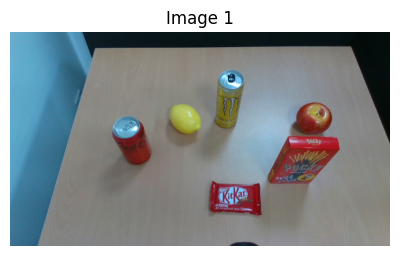

[USER_MSG]


Describe the objects in the image.
You need to annotate each object's name.
Format:
{
    "<object_name>": "<object_name>",
    "<brand_name>": "<brand_name>",
    "<object_shape>": "<object_shape>",
    "<object_color>": "<object_color>",
    "<object_type>": "<object_type>"
}
# Rule: If you don't know the answer, please fill in "unknown".



[GPT_OUTPUT]

{
    "object_name_1": "Soda Can",
    "brand_name_1": "Coca-Cola",
    "object_shape_1": "Cylinder",
    "object_color_1": "Red",
    "object_type_1": "Beverage",

    "object_name_2": "Lemon",
    "brand_name_2": "unknown",
    "object_shape_2": "Oval",
    "object_color_2": "Yellow",
    "object_type_2": "Fruit",

    "object_name_3": "Energy Drink Can",
    "brand_name_3": "unknown",
    "object_shape_3": "Cylinder",
    "object_color_3": "Yellow",
    "object_type_3": "Beverage",

    "object_name_4": "Apple",
    "brand_name_4": "unknown",
    "object_shape_4": "Round",
    "object_color_4": "Red",
    "object_type_4": "Fruit",

    "object_name_5": "Snack Stick Box",
    "brand_name_5": "Pocky",
    "object_shape_5": "Rectangular Prism",
    "object_color_5": "Red",
    "object_type_5": "Snack",

    "object_name_6": "Chocolate Bar",
    "brand_name_6": "KitKat",
    "object_shape_6": "Rectangle",
    "object_color_6": "Red",
    "object_type_6": "Confectionery"
}


In [7]:
object_names = ["pocky", "monster_drink", "lemon", "apple", "coke", "kitkat"]
query_text = """
Describe the objects in the image.
You need to annotate each object's name.
Format:
{
    "<object_name>": "<object_name>",
    "<brand_name>": "<brand_name>",
    "<object_shape>": "<object_shape>",
    "<object_color>": "<object_color>",
    "<object_type>": "<object_type>"
}
# Rule: If you don't know the answer, please fill in "unknown".
"""

# There are three types of objects in the image: [Snack, Drink, Fruit].
# only using the following object names: {object_names}.

response_interaction = model.chat(query_text=query_text, image_paths=['./clean_image_5.png'], images=None,
                            PRINT_USER_MSG=True,
                            PRINT_GPT_OUTPUT=True,
                            RESET_CHAT=False,
                            RETURN_RESPONSE=True,
                            VISUALIZE=True,
                            DETAIL='high')
response_interaction_json, error_message = response_to_json(response_interaction)

DETAIL: high

[0/1] image_path: ./clean_image.png


[VISUALIZE]

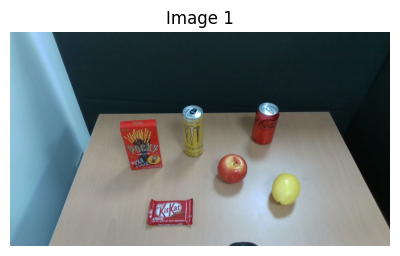

In [5]:
system_prompt ="""
You need to generate the scene graph for the following image.
e.g., 
Node: 1. [object id]
        - attribute: color, shape, brand_name
      2. [object id]
        - attribute: color, shape
Edge: 1. [obj 1] is [{spatial relationship 1}, {spatial relationship 2}] of [obj 2]

note: spatial relationship can be one of the following
left, right, on top of, below, in front of, behind
Try to list up all the relationships between the objects.
Brand name should be a proper noun.
The object id is a number written on the object.
"""

model.messages = model.init_messages
model.set_common_prompt(system_prompt)
model._backup_chat()

object_names = ["pocky", "monster_drink", "lemon", "apple", "coke", "kitkat"]
query_text = f"""
And then build the scene graph with the objects only on the table"
"""
# only using the following object names: {object_names}.

response_interaction = model.chat(query_text=query_text, image_paths=['./clean_image.png'], images=None,
                            PRINT_USER_MSG=True,
                            PRINT_GPT_OUTPUT=True,
                            RESET_CHAT=False,
                            RETURN_RESPONSE=True,
                            VISUALIZE=True,
                            DETAIL='high')
response_interaction_json, error_message = response_to_json(response_interaction)

In [9]:
np.rad2deg([-0.7,  -1.9,   2.36,  0.14,  0.96, -0.37])

array([ -40.10704566, -108.86198107,  135.21803965,    8.02140913,
         55.00394833,  -21.19943842])

In [6]:
np.rad2deg([-0.77, -1.77,  2.59, -0.36,  0.86, -0.32])

array([ -44.11775023, -101.41352974,  148.39606894,  -20.62648062,
         49.27437038,  -18.33464944])

In [4]:
# Capture View
np.rad2deg([-0.8,  -1.98,  1.91,  1.26,  1.2,  -0.73])

array([ -45.83662361, -113.44564344,  109.43493887,   72.19268219,
         68.75493542,  -41.82591904])